In [28]:
# ! pip install -r ../../requirements.txt

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
import time
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df_present = pd.read_csv('../../dataset/air_system_present_year.csv')
df_previous = pd.read_csv('../../dataset/air_system_previous_years.csv')

# Selected columns based on visual correlations
selected_columns = [
    'ag_005', 'az_005', 'ba_000', 'bb_000', 'bx_000', 'bu_000', 'bv_000', 
    'cc_000', 'ci_000', 'cn_004', 'cn_005', 'cq_000', 'cs_005', 
    'ee_002', 'ee_003', 'ee_004', 'ad_000'
]

In [30]:
# CALCULATE real values and  predict values custs, for statical comparsion
def calcular_custo_com_modelo(y_true, y_pred):
    tp = ((y_pred == 1) & (y_true == 1)).sum() #true-positive
    fp = ((y_pred == 1) & (y_true == 0)).sum() #false-positive
    fn = ((y_pred == 0) & (y_true == 1)).sum() #false-negative

    custo_total = (tp * 25) + (fp * 10) + (fn * 500)
    return custo_total

# Take the mean of columns
mean_previous = df_previous.apply(pd.to_numeric, errors='coerce').mean()
mean_present = df_present.apply(pd.to_numeric, errors='coerce').mean()

# Replace 'na' pela média das colunas
df_previous = df_previous.apply(lambda x: x.replace('na', mean_previous[x.name]) if x.name in mean_previous.index else x)
df_present = df_present.apply(lambda x: x.replace('na', mean_present[x.name]) if x.name in mean_present.index else x)

# Replace the column [ad_000] to mean:
df_previous.fillna({'ad_000': mean_previous['ad_000']}, inplace=True)
df_present.fillna({'ad_000': mean_previous['ad_000']}, inplace=True)

# Tratament Class to Binary Boolean
df_previous['class_binary'] = df_previous['class'].apply(lambda x: 1 if x == 'pos' else 0)
df_present['class_binary'] = df_present['class'].apply(lambda x: 1 if x == 'pos' else 0)

#### # Next cell are a Exploratory Analysis and Feature Selections


In [31]:
# # I started here for understanding the importance of columns and their weights, filtering data.
# numeric_cols = df_previous.select_dtypes(include='number')
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=numeric_cols.T, orient='v')
# plt.title('Boxplot Columns')
# plt.xticks(rotation=90)
# # plt.savefig('boxplot_columns.png')
# plt.show()

# # Methods that i used to view temperature for columns pos filtering with most importance and weight for Predict Train
# df_selected = df_previous[selected_columns]
# correlation_matrix = df_selected.corr()
# plt.figure(figsize=(8, 5)) 
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title('Correlation Matrix')
# # plt.savefig('correlation_columns.png')
# plt.show() 

#### # Continue the flux

In [32]:
# Separate feature columns from target columns
X = df_previous[selected_columns]
y = df_previous['class_binary']
X_present = df_present[selected_columns]
y_present = df_present['class_binary']

# Split data size 0.2 to test and 0.8 to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to reduce unbalanced classes between low positive cases
smote = SMOTE(random_state=64)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardized data processing
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)
X_present = scaler.transform(X_present)

### # Randomize search params:

In [33]:
# # When using this randomization, it is not necessary to use the next RUN cell. The next cell is used when the parameter values are defined.
# # Parameters range for random search
# param_dist = {
#     'n_estimators': randint(50, 600),  # Número de árvores na floresta
#     'max_depth': randint(1, 250),  # Profundidade máxima da árvore
#     'min_samples_split': randint(2, 30),  # Número mínimo de amostras necessárias para dividir um nó
#     'min_samples_leaf': randint(1, 8),  # Número mínimo de amostras em um nó folha
# }

# # For security not lost values, sabe the best params in .txt
# best_params_file = '../../results/best_params.txt'

# def save_best_params(best_params, runtime):
#     with open(best_params_file, 'w') as file:
#         file.write(f"Best hyperparams:\n{best_params}\n")
#         file.write(f"Total time run: {runtime:.2f} segundos")

# # Create RandomizedSearchCV Object
# random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(random_state=32), 
#     param_distributions=param_dist, 
#     n_iter=50,
#     scoring='recall',
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# # Fit the model using random search
# start_time = time.time()
# random_search.fit(X_train_resampled, y_train_resampled)
# elapsed_time = time.time() - start_time

# # Get the best model and final hyperparams
# best_model = random_search.best_estimator_
# best_params = random_search.best_params_

# print("Best finally found hyperparams:", best_params)
# save_best_params(best_params, elapsed_time)

In [34]:
# # WHO IS THE BEST?
# params_list = [
#     {'max_depth': 216, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 324},
#     {'max_depth': 91, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 506},
#     {'max_depth': 93, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 336}
# ]

# best_f1_score = 0.0
# best_params = None

# for i, params in enumerate(params_list):
#     model = RandomForestClassifier(**params, random_state=64, verbose=2)
#     model.fit(X_train_resampled, y_train_resampled)
#     y_pred = model.predict(X_test)
    
#     f1 = f1_score(y_test, y_pred)
#     print(f"F1-score para o modelo {i+1}: {f1}")
    
#     if f1 > best_f1_score:
#         best_f1_score = f1
#         best_params = params

# print("\nBest model found:")
# print(f"Params: {best_params}")
# print(f"Best F1-score: {best_f1_score}")

### # Use defined params:

In [35]:
# These parameters are hard-coded, obtained from randomization. To visualize detailed iterations, change verbose to 2.
# These parameters are a copy of the best_params, the best result found from the randomizer. Check ../../results and {paste}/{copy here} to test other best parameters found.
# For multiple process 'n_job = (number_of_paralels)'.

params = {'max_depth': 216, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 324} #50 iteration best param chosen
# params = {'max_depth': 91, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 506} #30 iteration best param found
# params = {'max_depth': 93, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 336} #20 iteration best param found

model = RandomForestClassifier(  **params, random_state=64, verbose=1, n_jobs=2)
model.fit(X_train_resampled, y_train_resampled)
print("Training completed.")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   30.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.7min


Training completed.


[Parallel(n_jobs=2)]: Done 324 out of 324 | elapsed:  4.2min finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 324 out of 324 | elapsed:    0.5s finished



Metric Eval Test Data:
Accuracy: 0.9826666666666667
Precision: 0.5063291139240507
Recall: 0.7547169811320755
F1-Score: 0.6060606060606061
ROC: 0.8707415920251488
Confusion Matrix (Teste):
 [[11632   156]
 [   52   160]]


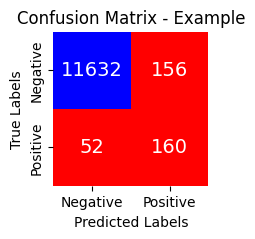

In [36]:
# Make predict
y_pred = model.predict(X_test)

# Evaluate test data
print("\nMetric Eval Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")
print(f"ROC: {roc_auc_score(y_test, y_pred)}")
print(f"Confusion Matrix (Teste):\n {confusion_matrix(y_test, y_pred)}") 

plt.figure(figsize=(2, 2))
cm = confusion_matrix(y_test, y_pred)
cmap_colors = ['red', 'blue']
sns.heatmap(cm, cmap=cmap_colors, annot=True, fmt='d', cbar=False,
            annot_kws={"size": 14}, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Example')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 324 out of 324 | elapsed:    0.5s finished



Metric Preidct 'Present Year':
Accuracy: 0.9821261171176802
Precision: 0.6032482598607889
Recall: 0.6933333333333334
F1-Score: 0.6451612903225806
ROC: 0.8411950168522548
Confusion Matrix (Present Year):
 [[15455   171]
 [  115   260]]


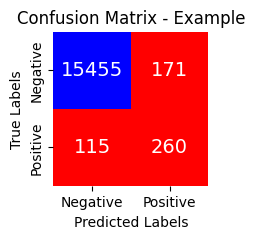

In [37]:
# Evaluate val data
y_pred_present = model.predict(X_present)

print("\nMetric Preidct 'Present Year':")
print(f"Accuracy: {accuracy_score(y_present, y_pred_present)}")
print(f"Precision: {precision_score(y_present, y_pred_present)}")
print(f"Recall: {recall_score(y_present, y_pred_present)}")
print(f"F1-Score: {f1_score(y_present, y_pred_present)}")
print(f"ROC: {roc_auc_score(y_present, y_pred_present)}")
print(f"Confusion Matrix (Present Year):\n {confusion_matrix(y_present, y_pred_present)}") 

plt.figure(figsize=(2, 2))
cm = confusion_matrix(y_present, y_pred_present)
cmap_colors = ['red', 'blue']
sns.heatmap(cm, cmap=cmap_colors, annot=True, fmt='d', cbar=False,
            annot_kws={"size": 14}, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Example')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### # Final Step to Action

In [43]:
# Suponhamos que você já tenha seu DataFrame df_saida com todas as colunas necessárias

# Criar DataFrame de Saída
df_saida = pd.DataFrame({
    'id_truck': df_present.index,  # Assumindo que os IDs de caminhão podem ser usados como índices
    'predict_class': y_pred_present,  # Usar as previsões do 'Present Year'
    'class_binary': y_present  # Adicionar a original class (class_binary)
})

# Direct count to brute verify values for predict maked and original classes on present year.
count_pred = np.bincount(y_pred_present)
count_present = np.bincount(y_present)
difference = count_pred - count_present

print("\nDirect count from 'present year' and 'predict present year' maintenance trucks: \n")
print(f"* Present_year_real_values: {count_present[0]} neg and {count_present[1]} pos.")
print(f"* Present_year_pred_values: {count_pred[0]} neg and {count_pred[1]} pos.\n")
print(f"-------------- * Difference: {difference[0]} neg and {difference[1]} pos. \n")

# Define decision thresholds and corresponding actions
threshold_now = 0.7
threshold_maybe = 0.5
cost_now = 25
cost_maybe = 10
cost_not_now = 500

# Função para calcular o custo original com base na original_class
def calculate_original_cost(class_value):
    if class_value == 1:
        return cost_now
    elif class_value == 0:
        return cost_not_now
    else:
        return np.nan  # ou outro valor padrão se necessário

# Marcar os caminhões que precisam de manutenção com base no threshold obtido de predict_class
df_saida['maintenance_action'] = pd.cut(df_saida['predict_class'], bins=[-np.inf, threshold_maybe, threshold_now, np.inf], labels=['no_maintenance', 'maybe_needed', 'maintenance_now'])

# Calcular o custo associado a cada caminhão com base na ação determinada
df_saida['maintenance_cost'] = df_saida['maintenance_action'].map({
    'maintenance_now': cost_now,
    'maybe_needed': cost_maybe,
    'no_maintenance': cost_not_now
})

# Calcular o custo original associado a cada caminhão com base na class_binary
df_saida['original_cost'] = df_saida['class_binary'].apply(calculate_original_cost)

# Adicionar a coluna de threshold obtida de predict_class
df_saida['threshold_predict'] = df_saida['predict_class'].astype(float)

# Imprimir caminhões que precisam de manutenção com custos associados, classes originais e thresholds
print("Trucks needing maintenance:")
maintenance_trucks = df_saida[df_saida['maintenance_action'] != 'no_maintenance'][['id_truck', 'predict_class', 'class_binary', 'maintenance_action', 'maintenance_cost', 'original_cost', 'threshold_predict']].head(50)
display(maintenance_trucks)


Direct count from 'present year' and 'predict present year' maintenance trucks: 

* Present_year_real_values: 15626 neg and 375 pos.
* Present_year_pred_values: 15570 neg and 431 pos.

-------------- * Difference: -56 neg and 56 pos. 

Trucks needing maintenance:


,id_truck,predict_class,class_binary,maintenance_action,maintenance_cost,original_cost,threshold_predict
107,107,1,0,maintenance_now,25,500,1.0
346,346,1,0,maintenance_now,25,500,1.0
417,417,1,0,maintenance_now,25,500,1.0
427,427,1,1,maintenance_now,25,25,1.0
435,435,1,1,maintenance_now,25,25,1.0
444,444,1,1,maintenance_now,25,25,1.0
460,460,1,0,maintenance_now,25,500,1.0
466,466,1,1,maintenance_now,25,25,1.0
487,487,1,1,maintenance_now,25,25,1.0
488,488,1,1,maintenance_now,25,25,1.0
